# Collaborative Recommendation Systems using Matrix Factorization with TensorFlow

Matrix Factorization | Machine Learning (no date) Google for Developers. Available at: https://developers.google.com/machine-learning/recommendation/collaborative/matrix (Accessed: 30 January 2024).

In [1]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
tf.compat.v1.enable_eager_execution()
tf.config.run_functions_eagerly(True)
# tf.disable_v2_behavior()
# tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format

In [4]:
input_file_path = '/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/crs_ds/data/processed/movieLense'
output_files = '/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/crs_ds/data/processed/outputs'

In [5]:
def read_file(file_name):
    return pd.read_csv(open(f"{input_file_path}/{file_name}", 'r'))

In [6]:
def write_file(df,file_name):
    return df.to_csv(f"{output_files}/{file_name}", index=False)

In [7]:
import re

def remove_special_characters(text):
    '''Function to clean up any given text by removing non alphanumeric characters with spaces'''
    # Define a pattern to keep only alphanumeric characters
    pattern = re.compile(r'[^a-zA-Z0-9\s]')

    # Use the pattern to replace non-alphanumeric characters with an empty string
    cleaned_text = re.sub(pattern, '', text)

    return cleaned_text

# Load Datasets

In [8]:
users = read_file('users.csv')
users.head()
ratings = read_file('ratings_short.csv')
ratings.head()
movies = read_file('movies_combined_cleaned_title.csv')
movies.head()

,id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


,user_id,movie_id,imdb_id,rating
0,1,1,tt0114709,5
1,2,1,tt0114709,4
2,5,1,tt0114709,4
3,6,1,tt0114709,4
4,10,1,tt0114709,4


,ml_id,title,release_year,imdb_id,unknown,Action,Adventure,Animation,Children's,Comedy,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,plot_summary,crew,genre_tags,cleaned_title
0,1,Toy Story,1995,tt0114709,0,0,0,1,1,1,...,0,0,0,0,0,0,Woody is a pull-string cowboy doll and leader ...,"[{""category"":""writer"",""crew_name"":""Joel Cohen""...","Animation, childrens, comedy",toystory
1,2,GoldenEye,1995,tt0097446,0,1,1,0,0,0,...,0,0,0,1,0,0,NaN,"[{""category"":""composer"",""crew_name"":""Michael B...","action, adventure, thriller",goldeneye
2,3,Four Rooms,1995,tt0113101,0,0,0,0,0,0,...,0,0,0,1,0,0,"The film is set on New Year's Eve, and starts ...","[{""category"":""producer"",""crew_name"":""Lawrence ...",thriller,fourrooms
3,4,Get Shorty,1995,tt0113161,0,1,0,0,0,1,...,0,0,0,0,0,0,"Chili Palmer , a loan shark based in Miami, cl...","[{""category"":""composer"",""crew_name"":""John Luri...","action, comedy, drama",getshorty
4,5,Copycat,1995,tt0112722,0,0,0,0,0,0,...,0,0,0,1,0,0,After giving a guest lecture on criminal psych...,"[{""category"":""composer"",""crew_name"":""Christoph...","crime, drama, thriller",copycat


In [9]:
genres = read_file('entity_movie_genres.csv')
genres

,genres
0,Documentary
1,Animation
2,Comedy
3,Short
4,Romance
...,...
23,Film-Noir
24,Talk-Show
25,Game-Show
26,Adult


In [10]:
genre_c_name=list(genres['genres'])

In [11]:
movies.head(3)

,ml_id,title,release_year,imdb_id,unknown,Action,Adventure,Animation,Children's,Comedy,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,plot_summary,crew,genre_tags,cleaned_title
0,1,Toy Story,1995,tt0114709,0,0,0,1,1,1,...,0,0,0,0,0,0,Woody is a pull-string cowboy doll and leader ...,"[{""category"":""writer"",""crew_name"":""Joel Cohen""...","Animation, childrens, comedy",toystory
1,2,GoldenEye,1995,tt0097446,0,1,1,0,0,0,...,0,0,0,1,0,0,NaN,"[{""category"":""composer"",""crew_name"":""Michael B...","action, adventure, thriller",goldeneye
2,3,Four Rooms,1995,tt0113101,0,0,0,0,0,0,...,0,0,0,1,0,0,"The film is set on New Year's Eve, and starts ...","[{""category"":""producer"",""crew_name"":""Lawrence ...",thriller,fourrooms


In [12]:
def create_combined_genre(x):
    """Creates combines genres

    Args:
        x (dataframe row): row of movie dataframe

    Returns:
        appended tags: creates list of appended tags
    """
    genre_tags=[]
    if x["Action"] == 1:
        genre_tags.append("action")
    if x["Adventure"] == 1:
        genre_tags.append("adventure")
    if x["Animation"] == 1:
        genre_tags.append("Animation")
    if x["Children's"] == 1:
        genre_tags.append("childrens")
    if x["Crime"] == 1:
        genre_tags.append("crime")
    if x["Comedy"] == 1:
        genre_tags.append("comedy")
    if x["Documentary"] == 1:
        genre_tags.append("documentary")
    if x["Drama"] == 1:
        genre_tags.append("drama")
    if x["Fantasy"] == 1:
        genre_tags.append("fantasy")
    if x["Film-Noir"] == 1:
        genre_tags.append("film-Noir")
    if x["Horror"] == 1:
        genre_tags.append("horror")
    if x["Musical"] == 1:
        genre_tags.append("musical")
    if x["Mystery"] == 1:
        genre_tags.append("mystery")
    if x["Romance"] == 1:
        genre_tags.append("romance")
    if x["Sci-Fi"] == 1:
        genre_tags.append("sci-fi")
    if x["Thriller"] == 1:
        genre_tags.append("thriller")
    if x["War"] == 1:
        genre_tags.append("war")
    if x["Western"] == 1:
        genre_tags.append("western")
    return genre_tags


In [13]:
# create the genre tag which is combined list of genres
for index, row in movies.iterrows():
    genre_tags = create_combined_genre(row)
    movies.at[index, 'genre_tags'] =  ', '.join(genre_tags)

In [14]:
movies

,ml_id,title,release_year,imdb_id,unknown,Action,Adventure,Animation,Children's,Comedy,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,plot_summary,crew,genre_tags,cleaned_title
0,1,Toy Story,1995,tt0114709,0,0,0,1,1,1,...,0,0,0,0,0,0,Woody is a pull-string cowboy doll and leader ...,"[{""category"":""writer"",""crew_name"":""Joel Cohen""...","Animation, childrens, comedy",toystory
1,2,GoldenEye,1995,tt0097446,0,1,1,0,0,0,...,0,0,0,1,0,0,NaN,"[{""category"":""composer"",""crew_name"":""Michael B...","action, adventure, thriller",goldeneye
2,3,Four Rooms,1995,tt0113101,0,0,0,0,0,0,...,0,0,0,1,0,0,"The film is set on New Year's Eve, and starts ...","[{""category"":""producer"",""crew_name"":""Lawrence ...",thriller,fourrooms
3,4,Get Shorty,1995,tt0113161,0,1,0,0,0,1,...,0,0,0,0,0,0,"Chili Palmer , a loan shark based in Miami, cl...","[{""category"":""composer"",""crew_name"":""John Luri...","action, comedy, drama",getshorty
4,5,Copycat,1995,tt0112722,0,0,0,0,0,0,...,0,0,0,1,0,0,After giving a guest lecture on criminal psych...,"[{""category"":""composer"",""crew_name"":""Christoph...","crime, drama, thriller",copycat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658,1677,Sweet Nothing,1996,tt0100724,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,"[{""category"":""cinematographer"",""crew_name"":""Pa...",drama,sweetnothing
1659,1678,Mat' i syn,1998,tt0119711,0,0,0,0,0,0,...,0,0,0,0,0,0,"{{Cleanup}} The film opens on two human forms,...","[{""category"":""production_designer"",""crew_name""...",drama,matisyn
1660,1679,B. Monkey,1998,tt0016122,0,0,0,0,0,0,...,0,1,0,1,0,0,NaN,"[{""category"":""director"",""crew_name"":""Earl Hurd""}]","romance, thriller",bmonkey
1661,1681,You So Crazy,1994,tt0111804,0,0,0,0,0,1,...,0,0,0,0,0,0,NaN,"[{""category"":""director"",""crew_name"":""Thomas Sc...",comedy,yousocrazy


## Preprocessing

In [15]:
# Check for the shape of each users, item(movies) and ratings
users.shape
ratings.shape
movies.shape

(943, 5)

(99383, 4)

(1663, 27)

In [16]:
# Check for duplications
users.duplicated().sum()
ratings.duplicated().sum()
movies.duplicated().sum()

0

0

0

In [17]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99383 entries, 0 to 99382
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   99383 non-null  int64 
 1   movie_id  99383 non-null  int64 
 2   imdb_id   99383 non-null  object
 3   rating    99383 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.0+ MB


In [18]:
# Get the list of user ids who have rated the movies
user_ids = ratings["user_id"].unique().tolist()

In [19]:
# Enumerate the user id list to retain their indices => Given a user, allows to retrieve index
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user2user_encoded
# Retrieve index for user 42 (user_id,index)
user2user_encoded[42]

{1: 0,
 2: 1,
 5: 2,
 6: 3,
 10: 4,
 13: 5,
 15: 6,
 16: 7,
 17: 8,
 18: 9,
 20: 10,
 21: 11,
 23: 12,
 25: 13,
 26: 14,
 38: 15,
 41: 16,
 42: 17,
 43: 18,
 44: 19,
 45: 20,
 49: 21,
 54: 22,
 56: 23,
 57: 24,
 58: 25,
 59: 26,
 62: 27,
 63: 28,
 64: 29,
 65: 30,
 66: 31,
 67: 32,
 70: 33,
 72: 34,
 73: 35,
 75: 36,
 77: 37,
 79: 38,
 81: 39,
 82: 40,
 83: 41,
 84: 42,
 89: 43,
 92: 44,
 93: 45,
 94: 46,
 95: 47,
 96: 48,
 97: 49,
 99: 50,
 101: 51,
 102: 52,
 106: 53,
 108: 54,
 109: 55,
 117: 56,
 120: 57,
 121: 58,
 124: 59,
 125: 60,
 128: 61,
 130: 62,
 131: 63,
 134: 64,
 137: 65,
 138: 66,
 141: 67,
 144: 68,
 145: 69,
 148: 70,
 150: 71,
 151: 72,
 157: 73,
 158: 74,
 160: 75,
 162: 76,
 168: 77,
 174: 78,
 177: 79,
 178: 80,
 181: 81,
 182: 82,
 184: 83,
 189: 84,
 193: 85,
 194: 86,
 198: 87,
 199: 88,
 200: 89,
 201: 90,
 202: 91,
 203: 92,
 204: 93,
 209: 94,
 210: 95,
 213: 96,
 216: 97,
 222: 98,
 223: 99,
 230: 100,
 231: 101,
 232: 102,
 234: 103,
 235: 104,
 242: 105,

17

In [20]:
# Create a list of index and users ids => Given an index, returns the user id
userencoded2user = {i: x for i, x in enumerate(user_ids)}
userencoded2user
# Retrive user based on index (index,user_id)

{0: 1,
 1: 2,
 2: 5,
 3: 6,
 4: 10,
 5: 13,
 6: 15,
 7: 16,
 8: 17,
 9: 18,
 10: 20,
 11: 21,
 12: 23,
 13: 25,
 14: 26,
 15: 38,
 16: 41,
 17: 42,
 18: 43,
 19: 44,
 20: 45,
 21: 49,
 22: 54,
 23: 56,
 24: 57,
 25: 58,
 26: 59,
 27: 62,
 28: 63,
 29: 64,
 30: 65,
 31: 66,
 32: 67,
 33: 70,
 34: 72,
 35: 73,
 36: 75,
 37: 77,
 38: 79,
 39: 81,
 40: 82,
 41: 83,
 42: 84,
 43: 89,
 44: 92,
 45: 93,
 46: 94,
 47: 95,
 48: 96,
 49: 97,
 50: 99,
 51: 101,
 52: 102,
 53: 106,
 54: 108,
 55: 109,
 56: 117,
 57: 120,
 58: 121,
 59: 124,
 60: 125,
 61: 128,
 62: 130,
 63: 131,
 64: 134,
 65: 137,
 66: 138,
 67: 141,
 68: 144,
 69: 145,
 70: 148,
 71: 150,
 72: 151,
 73: 157,
 74: 158,
 75: 160,
 76: 162,
 77: 168,
 78: 174,
 79: 177,
 80: 178,
 81: 181,
 82: 182,
 83: 184,
 84: 189,
 85: 193,
 86: 194,
 87: 198,
 88: 199,
 89: 200,
 90: 201,
 91: 202,
 92: 203,
 93: 204,
 94: 209,
 95: 210,
 96: 213,
 97: 216,
 98: 222,
 99: 223,
 100: 230,
 101: 231,
 102: 232,
 103: 234,
 104: 235,
 105: 242,

In [21]:
# Store the index of user ids enumerated
ratings["user"] = ratings["user_id"].map(user2user_encoded)

In [22]:
ratings.head()

,user_id,movie_id,imdb_id,rating,user
0,1,1,tt0114709,5,0
1,2,1,tt0114709,4,1
2,5,1,tt0114709,4,2
3,6,1,tt0114709,4,3
4,10,1,tt0114709,4,4


In [23]:
# Extract all movies which have been rated
movie_ids = ratings["movie_id"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie2movie_encoded
# Returns index of movie (movie_id,index)
movie2movie_encoded[34]

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 33: 32,
 34: 33,
 35: 34,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 51: 50,
 52: 51,
 53: 52,
 54: 53,
 55: 54,
 56: 55,
 57: 56,
 58: 57,
 59: 58,
 60: 59,
 61: 60,
 62: 61,
 63: 62,
 64: 63,
 65: 64,
 66: 65,
 67: 66,
 68: 67,
 69: 68,
 70: 69,
 71: 70,
 72: 71,
 73: 72,
 74: 73,
 75: 74,
 76: 75,
 77: 76,
 78: 77,
 79: 78,
 80: 79,
 81: 80,
 82: 81,
 83: 82,
 84: 83,
 85: 84,
 86: 85,
 87: 86,
 88: 87,
 89: 88,
 90: 89,
 91: 90,
 92: 91,
 93: 92,
 94: 93,
 95: 94,
 96: 95,
 97: 96,
 98: 97,
 99: 98,
 100: 99,
 101: 100,
 102: 101,
 103: 102,
 104: 103,
 105: 104,
 106: 105,
 107: 106,
 108: 107,
 109: 108,
 110: 109,
 111: 11

33

In [24]:
# Create a list of index and movie ids => Given an index, returns the movie id
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
movie_encoded2movie
# Returns the movie for an index (index,movie_id)
movie_encoded2movie[7]

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20,
 20: 21,
 21: 22,
 22: 23,
 23: 24,
 24: 25,
 25: 26,
 26: 27,
 27: 28,
 28: 29,
 29: 30,
 30: 31,
 31: 32,
 32: 33,
 33: 34,
 34: 35,
 35: 36,
 36: 37,
 37: 38,
 38: 39,
 39: 40,
 40: 41,
 41: 42,
 42: 43,
 43: 44,
 44: 45,
 45: 46,
 46: 47,
 47: 48,
 48: 49,
 49: 50,
 50: 51,
 51: 52,
 52: 53,
 53: 54,
 54: 55,
 55: 56,
 56: 57,
 57: 58,
 58: 59,
 59: 60,
 60: 61,
 61: 62,
 62: 63,
 63: 64,
 64: 65,
 65: 66,
 66: 67,
 67: 68,
 68: 69,
 69: 70,
 70: 71,
 71: 72,
 72: 73,
 73: 74,
 74: 75,
 75: 76,
 76: 77,
 77: 78,
 78: 79,
 79: 80,
 80: 81,
 81: 82,
 82: 83,
 83: 84,
 84: 85,
 85: 86,
 86: 87,
 87: 88,
 88: 89,
 89: 90,
 90: 91,
 91: 92,
 92: 93,
 93: 94,
 94: 95,
 95: 96,
 96: 97,
 97: 98,
 98: 99,
 99: 100,
 100: 101,
 101: 102,
 102: 103,
 103: 104,
 104: 105,
 105: 106,
 106: 107,
 107: 108,
 108: 109,
 109: 110,
 110: 11

8

In [25]:
# Store the index of movie ids enumerated
ratings["movie"] = ratings["movie_id"].map(movie2movie_encoded)
ratings.head(3)

,user_id,movie_id,imdb_id,rating,user,movie
0,1,1,tt0114709,5,0,0
1,2,1,tt0114709,4,1,0
2,5,1,tt0114709,4,2,0


In [26]:
# Number of unique users and movies
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
# Ratings are converted to float
ratings["rating"] = ratings["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(ratings["rating"])
max_rating = max(ratings["rating"])
# Summary
print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 943, Number of Movies: 1663, Min rating: 1.0, Max rating: 5.0


# Matrix Factorisation
Our goal is to factorize the ratings matrix $A$ into the product of a user embedding matrix $U$ and movie embedding matrix $V$, such that $A \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Here
- $N$ is the number of users,
- $M$ is the number of movies,
- $A_{ij}$ is the rating of the $j$th movies by the $i$th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each row $V_j$ is a $d$-dimensional vector (embedding) representing movie $j$,
- the prediction of the model for the $(i, j)$ pair is the dot product $\langle U_i, V_j \rangle$.

We can solve this quadratic problem through Singular Value Decomposition (SVD) of the matrix. However, SVD is not a great solution either, because in real applications, the matrix may be very sparse. For example, think of all the videos on YouTube compared to all the videos a particular user has viewed. The solution UV^T(which corresponds to the model's approximation of the input matrix) will likely be close to zero, leading to poor generalization performance.

In contrast, Weighted Matrix Factorization decomposes the objective into the following two sums:

- A sum over observed entries.
- A sum over unobserved entries (treated as zeroes).

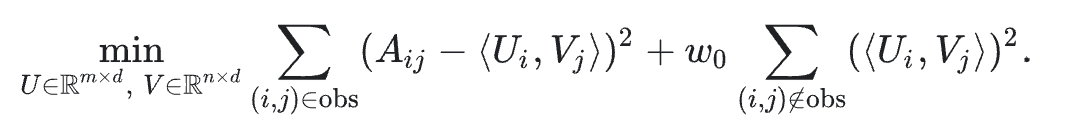

Here, 
 w0 is a hyperparameter that weights the two terms so that the objective is not dominated by one or the other. Tuning this hyperparameter is very important.



## Split data in train and test

In [27]:
from sklearn.model_selection import train_test_split
def split_dataframe(df):
    X_train, X_test = train_test_split(df, test_size=0.1, random_state=42)
    X_train.shape
    X_test.shape
    return X_train,X_test

## Create Ratings sparse tensors

In [28]:
# Build ratings tensors
def build_rating_sparse_tensor(df):
    indices = df[['user_id','movie_id']].values
    values = df['rating'].values
    return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

## Training

In [29]:
# Function to compute Loss
def sparse_mean_square_error_observed_pairs_only(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(movie_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

### Define the model

In [30]:
# Iterate to minimise the loss between real ratings matrix A_train and dotproduct of U and V
def train(num_iterations=1000,learning_rate=10,optimizer=tf.keras.optimizers.legacy.SGD,init_stddev=1.0,embedding_dim=50,df=ratings):

    X_train,X_test = split_dataframe(df)
    # SparseTensor representation of the train and test datasets.
    # ============================================================
    A_train = build_rating_sparse_tensor(X_train)
    A_test = build_rating_sparse_tensor(X_test)
    # ============================================================

    # Initialize the embeddings using a normal distribution
    # ============================================================
    U = tf.Variable(tf.random_normal_initializer(stddev=init_stddev)(shape=[A_train.dense_shape[0], embedding_dim]))
    V = tf.Variable(tf.random_normal_initializer(stddev=init_stddev)(shape=[A_train.dense_shape[1], embedding_dim]))
    # ============================================================

    # Store loss results for plotting
    # ============================================================
    loss_result = pd.DataFrame(columns =['train_loss', 'test_loss','learning_rate',])
    # ============================================================

    # Iterate to minimise the loss between real ratings matrix A and dotproduct of U and V
    # ============================================================
    for i in range(num_iterations + 1):
        opt = optimizer(learning_rate)
        with tf.GradientTape() as tape:
            train_loss = sparse_mean_square_error_observed_pairs_only(A_train,U,V)
            test_loss = sparse_mean_square_error_observed_pairs_only(A_test,U,V)
            loss_result.loc[i] = [train_loss.numpy(), test_loss.numpy(),learning_rate,]
        # Compute the gradients for a list of variables.
        grads = tape.gradient(train_loss, [U,V])
        # Ask the optimizer to apply the gradients on variables.
        opt_emb = opt.apply_gradients(zip(grads,[U, V]))
        # learning_rate = learning_rate/10
    # ============================================================
    return loss_result,opt_emb,U,V

In [31]:
loss_result,opt_emb,U,V = train(num_iterations=1000,learning_rate=10,init_stddev=0.5,embedding_dim=30,df=ratings)

2024-02-18 14:22:01.118837: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-18 14:22:01.118880: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-18 14:22:01.118895: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-18 14:22:01.119111: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-18 14:22:01.119413: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [32]:
loss_result.shape
loss_result

(1001, 3)

,train_loss,test_loss,learning_rate
0,15.583,15.538,10.000
1,15.422,15.480,10.000
2,15.274,15.430,10.000
3,15.135,15.385,10.000
4,15.004,15.343,10.000
...,...,...,...
996,0.399,1.370,10.000
997,0.399,1.370,10.000
998,0.399,1.371,10.000
999,0.399,1.371,10.000


Text(0.5, 0, 'Iterations')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'SGD Optimiser for Loss function')

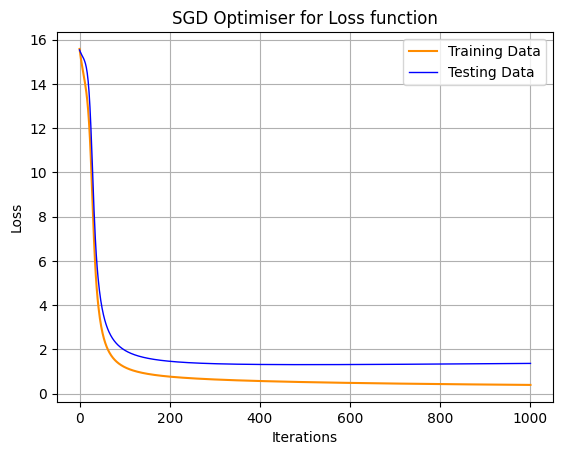

In [33]:
lw = 1
%matplotlib inline
plt.plot(loss_result.index, loss_result['train_loss'], color='darkorange', label='Training Data')
plt.plot(loss_result.index,loss_result['test_loss'], color='blue', linewidth=lw, label='Testing Data')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('SGD Optimiser for Loss function')
plt.legend()
plt.grid(True)
plt.show()

### Inspecting the Embeddings


In [34]:
# Optimised movie embeddings
V.numpy()

array([[-0.67720795,  0.35227466,  0.01833096, ..., -0.14869389,
        -0.66201985,  0.14392829],
       [-0.31060025, -0.3652113 ,  0.5312496 , ...,  0.16151552,
        -0.54867524, -0.16060036],
       [ 0.0074894 , -0.3524651 ,  0.53886175, ...,  0.2626295 ,
         0.1936091 ,  0.2151901 ],
       ...,
       [-0.2624681 , -1.6991963 , -0.6518977 , ...,  0.12616625,
        -0.06712271, -0.2214563 ],
       [ 0.7537068 ,  0.04071997,  0.37997743, ...,  0.00876178,
         0.17722283,  1.0354708 ],
       [-0.8862731 ,  0.18034978,  0.11558142, ...,  0.72099406,
         0.3607829 ,  1.1695025 ]], dtype=float32)

In [35]:
# Optimised user embeddings
U.numpy()

array([[ 0.19557388,  0.34853455,  0.61121255, ..., -0.31759974,
        -0.40908748, -0.46517622],
       [-0.2459812 , -0.2811983 ,  0.5446274 , ..., -0.12787803,
        -0.42157263,  0.701561  ],
       [ 0.04447882, -0.2310061 , -0.48714733, ..., -0.13952018,
        -0.33775473, -0.14280948],
       ...,
       [ 0.23706995, -1.0888624 ,  0.7653109 , ...,  0.7541086 ,
         0.14052545, -0.02392545],
       [ 0.18669242, -0.31895736,  1.1502954 , ...,  0.00914994,
        -0.83398944, -0.5538665 ],
       [-0.5215881 , -0.30212268, -0.11403027, ..., -0.0360771 ,
        -0.15871592, -0.23139581]], dtype=float32)

# Testing of recommendations

In [36]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  q = query_embedding
  I = item_embeddings
  if measure == COSINE:
    I = I / np.linalg.norm(I, axis=1, keepdims=True)
    q = q / np.linalg.norm(q)
  scores = q.dot(I.T)
  return scores

In [37]:
def user_recommendations(measure,query_embedding,item_embeddings):
    scores = compute_scores(query_embedding, item_embeddings, measure)
    score_key = measure+"_"+ 'score'
    df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['ml_id'],
        'titles': movies['title'],
        'genres': movies['genre_tags']
    })
    return df

### Testing using DOT product

In [38]:
# Testing of the recommendations
user_id = 10 # Recommendation for this user
measure=DOT # Use of DOT product or Cosine simialrity
exclude_rated = False # Flag to indicate if already rated movies by this user can be excluded from the final recommendation
k=6 # Number of movies to be recommended
# Create the query embeddings
query_embedding = U.numpy()[user_id]
item_embeddings = V.numpy()
df = user_recommendations(measure,query_embedding,item_embeddings)
score_key = measure+"_"+ 'score'
if exclude_rated:
    # remove movies that are already rated
    rated_movies = ratings[ratings.user_id == user_id]["movie_id"].values
    df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]

df.sort_values([score_key],ascending=False).head(k)

,dot_score,movie_id,titles,genres
1063,5.884,1074,Reality Bites,"comedy, drama"
1298,5.675,1310,"Walk in the Sun, A",drama
75,5.658,76,Carlito's Way,"crime, drama"
113,5.525,114,Wallace & Gromit: The Best of Aardman Animation,Animation
613,5.489,619,Extreme Measures,"drama, thriller"
1064,5.470,1075,"Man of No Importance, A",drama


In [39]:
# Create one merged DataFrame containing all the movielens data.
ml1 = pd.merge(ratings,movies,how='inner',left_on="movie_id",right_on="ml_id")
movielens = pd.merge(ml1,users,how='inner',left_on="user_id",right_on="id")

In [40]:
movielens.shape
movielens.head(4)

(99383, 38)

,user_id,movie_id,imdb_id_x,rating,user,movie,ml_id,title,release_year,imdb_id_y,...,Western,plot_summary,crew,genre_tags,cleaned_title,id,age,gender,occupation,zip_code
0,1,1,tt0114709,5.000,0,0,1,Toy Story,1995,tt0114709,...,0,Woody is a pull-string cowboy doll and leader ...,"[{""category"":""writer"",""crew_name"":""Joel Cohen""...","Animation, childrens, comedy",toystory,1,24,M,technician,85711
1,1,2,tt0097446,3.000,0,1,2,GoldenEye,1995,tt0097446,...,0,NaN,"[{""category"":""composer"",""crew_name"":""Michael B...","action, adventure, thriller",goldeneye,1,24,M,technician,85711
2,1,3,tt0113101,4.000,0,2,3,Four Rooms,1995,tt0113101,...,0,"The film is set on New Year's Eve, and starts ...","[{""category"":""producer"",""crew_name"":""Lawrence ...",thriller,fourrooms,1,24,M,technician,85711
3,1,4,tt0113161,3.000,0,3,4,Get Shorty,1995,tt0113161,...,0,"Chili Palmer , a loan shark based in Miami, cl...","[{""category"":""composer"",""crew_name"":""John Luri...","action, comedy, drama",getshorty,1,24,M,technician,85711


In [41]:
# Verify if the recommendations are accurate to users historic liking.
movielens[movielens["user_id"] == 10].sort_values(["rating"],ascending=False).head(5)[['user_id','movie_id','rating','title','genre_tags']]

,user_id,movie_id,rating,title,genre_tags
805,10,357,5.000,One Flew Over the Cuckoo's Nest,drama
764,10,179,5.000,"Clockwork Orange, A",sci-fi
853,10,531,5.000,Shine,"drama, romance"
770,10,191,5.000,Amadeus,"drama, mystery"
768,10,185,5.000,Psycho,"horror, romance, thriller"


### Testing using COSINE Similarity

In [42]:
# Testing of the recommendations
user_id = 10 # Recommendation for this user
measure=COSINE # Use of DOT product or Cosine simialrity
exclude_rated = False # Flag to indicate if already rated movies by this user can be excluded from the final recommendation
k=6 # Number of movies to be recommended
query_embedding = U.numpy()[user_id]
item_embeddings = V.numpy()
df = user_recommendations(measure,query_embedding,item_embeddings)
score_key = measure+"_"+ 'score'
if exclude_rated:
    # remove movies that are already rated
    rated_movies = ratings[ratings.user_id == user_id]["movie_id"].values
    df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]

df.sort_values([score_key],ascending=False).head(k)

,cosine_score,movie_id,titles,genres
484,0.787,489,Notorious,"film-Noir, romance, thriller"
483,0.786,488,Sunset Blvd.,film-Noir
193,0.777,194,"Sting, The","crime, comedy"
99,0.771,100,Fargo,"crime, drama, thriller"
12,0.771,13,Mighty Aphrodite,comedy
223,0.769,224,Ridicule,drama


### Movie Nearest neighbors (Search)

In [43]:
def movie_neighbours(title_substring, measure,k,query_embedding,item_embeddings):
    # Select the most matching title
    ids =  movies[movies['title'].str.contains(title_substring)].index.values
    titles = movies.iloc[ids]['title'].values
    if len(titles) == 0:
        raise ValueError("Found no movies with title %s" % title_substring)
    print("Nearest neighbors of : %s." % titles[0])
    if len(titles) > 1:
        print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))

    movie_id = ids[0]
    query_embedding = query_embedding[movie_id]
    # Calculating dot matrix this the most matched movie with other movie embeddings to find the other matching movies
    scores = compute_scores(query_embedding, item_embeddings, measure)
    score_key = measure+"_"+ 'score'

    df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['ml_id'],
        'titles': movies['title'],
        'genres': movies['genre_tags'],
    })
    return df

#### Using dot product

In [44]:
title_substring="Black" # String to find
measure=DOT # DOT or Cosine Similarity
k=6 # Number of movies to recommend
score_key = measure+"_"+ 'score'
query_embedding = V.numpy()
item_embeddings = V.numpy()
df = movie_neighbours(title_substring,measure,k,query_embedding,item_embeddings)
df.sort_values([score_key], ascending=False).head(k)

Nearest neighbors of : Men in Black .
[Found more than one matching movie. Other candidates: Black Sheep , Black Beauty , Fear of a Black Hat ]


,dot_score,movie_id,titles,genres
256,10.551,257,Men in Black,"action, adventure, comedy, sci-fi"
835,6.887,843,"Shaggy Dog, The","childrens, comedy"
474,6.337,479,Vertigo,"mystery, thriller"
1067,6.175,1078,Oliver & Company,"Animation, childrens"
529,6.139,535,Addicted to Love,"comedy, romance"
572,6.137,578,Demolition Man,"action, sci-fi"


#### Using cosine product

In [45]:
title_substring="Black" # String to find
measure=COSINE # DOT or Cosine Similarity
k=6 # Number of movies to recommend
score_key = measure+"_"+ 'score'
query_embedding = V.numpy()
item_embeddings = V.numpy()
df = movie_neighbours(title_substring,measure,k,query_embedding,item_embeddings)
df.sort_values([score_key], ascending=False).head(k)

Nearest neighbors of : Men in Black .
[Found more than one matching movie. Other candidates: Black Sheep , Black Beauty , Fear of a Black Hat ]


,cosine_score,movie_id,titles,genres
256,1.000,257,Men in Black,"action, adventure, comedy, sci-fi"
474,0.707,479,Vertigo,"mystery, thriller"
175,0.659,176,Aliens,"action, sci-fi, thriller, war"
13,0.657,14,"Postino, Il","drama, romance"
572,0.647,578,Demolition Man,"action, sci-fi"
10,0.630,11,Seven,"crime, thriller"


It seems that the quality of learned embeddings may not be very good. This is addressed in next Section by adding several regularization techniques. First, we will further inspect the embeddings.

### Impact hyper-parameter `init_stddev`
Note: Depending on how the model is initialized, one may observe that some niche movies (ones with few ratings) have a high norm, leading to spurious recommendations. This can happen if the embedding of that movie happens to be initialized with a high norm. Then, because the movie has few ratings, it is infrequently updated, and can keep its high norm. This will be alleviated by using regularization.
Try changing the value of the hyper-parameter `init_stddev`. One quantity that can be helpful is that the expected norm of a $d$-dimensional vector with entries $\sim \mathcal N(0, \sigma^2)$ is approximatley $\sigma \sqrt d$.

In [46]:
loss_result_lowinit,opt_emb_lowinit,U_lowinit,V_lowinit = train(num_iterations=1000,learning_rate=10,init_stddev=0.05,embedding_dim=30,df=ratings)

In [47]:
loss_result_lowinit

,train_loss,test_loss,learning_rate
0,13.723,13.764,10.000
1,13.722,13.764,10.000
2,13.721,13.764,10.000
3,13.720,13.764,10.000
4,13.719,13.764,10.000
...,...,...,...
996,0.381,0.976,10.000
997,0.380,0.976,10.000
998,0.380,0.977,10.000
999,0.380,0.977,10.000


Text(0.5, 0, 'Iterations')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'SGD Optimiser for Loss function with lowered standard deviation')

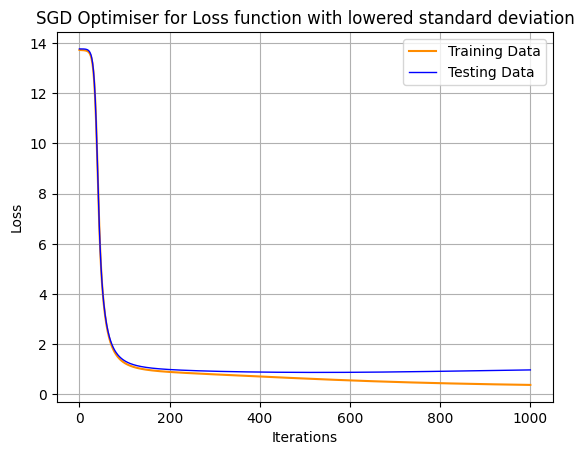

In [48]:
lw = 1
%matplotlib inline
plt.plot(loss_result_lowinit.index, loss_result_lowinit['train_loss'], color='darkorange', label='Training Data')
plt.plot(loss_result_lowinit.index,loss_result_lowinit['test_loss'], color='blue', linewidth=lw, label='Testing Data')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('SGD Optimiser for Loss function with lowered standard deviation')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# Testing of the recommendations
user_id = 10 # Recommendation for this user
measure=DOT # Use of DOT product or Cosine simialrity
exclude_rated = False # Flag to indicate if already rated movies by this user can be excluded from the final recommendation
k=6 # Number of movies to be recommended
# Create the query embeddings
query_embedding = U_lowinit.numpy()[user_id]
item_embeddings = V_lowinit.numpy()
df = user_recommendations(measure,query_embedding,item_embeddings)
score_key = measure+"_"+ 'score'
if exclude_rated:
    # remove movies that are already rated
    rated_movies = ratings[ratings.user_id == user_id]["movie_id"].values
    df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]

df.sort_values([score_key],ascending=False).head(k)

,dot_score,movie_id,titles,genres
127,5.373,128,Supercop,"action, thriller"
185,5.054,186,"Blues Brothers, The","action, comedy, musical"
1449,5.034,1461,Here Comes Cookie,comedy
483,5.024,488,Sunset Blvd.,film-Noir
603,4.936,609,Father of the Bride,comedy
190,4.928,191,Amadeus,"drama, mystery"


In [50]:
# Verify if the recommendations are accurate to users historic liking.
movielens[movielens["user_id"] == 10].sort_values(["rating"],ascending=False).head()

,user_id,movie_id,imdb_id_x,rating,user,movie,ml_id,title,release_year,imdb_id_y,...,Western,plot_summary,crew,genre_tags,cleaned_title,id,age,gender,occupation,zip_code
805,10,357,tt0073486,5.000,4,352,357,One Flew Over the Cuckoo's Nest,1975,tt0073486,...,0,"In 1963 Oregon, Randle Patrick ""Mac"" McMurphy ...","[{""category"":""producer"",""crew_name"":""Michael D...",drama,oneflewoverthecuckoosnest,10,53,M,lawyer,90703
764,10,179,tt0066921,5.000,4,178,179,"Clockwork Orange, A",1971,tt0066921,...,0,"In futuristic London, Alex is the leader of h...","[{""category"":""actor"",""crew_name"":""Malcolm McDo...",sci-fi,clockworkorangea,10,53,M,lawyer,90703
853,10,531,tt0021282,5.000,4,525,531,Shine,1996,tt0021282,...,0,NaN,"[{""category"":""actor"",""crew_name"":""Tom Howard""}...","drama, romance",shine,10,53,M,lawyer,90703
770,10,191,tt0086879,5.000,4,190,191,Amadeus,1984,tt0086879,...,0,:See the article Amadeus about the stage play ...,"[{""category"":""editor"",""crew_name"":""Michael Cha...","drama, mystery",amadeus,10,53,M,lawyer,90703
768,10,185,tt0054215,5.000,4,184,185,Psycho,1960,tt0054215,...,0,NaN,"[{""category"":""editor"",""crew_name"":""George Toma...","horror, romance, thriller",psycho,10,53,M,lawyer,90703


In [51]:
# Testing of the recommendations
user_id = 10 # Recommendation for this user
measure=COSINE # Use of DOT product or Cosine simialrity
exclude_rated = False # Flag to indicate if already rated movies by this user can be excluded from the final recommendation
k=6 # Number of movies to be recommended
# Create the query embeddings
query_embedding = U_lowinit.numpy()[user_id]
item_embeddings = V_lowinit.numpy()
df = user_recommendations(measure,query_embedding,item_embeddings)
score_key = measure+"_"+ 'score'
if exclude_rated:
    # remove movies that are already rated
    rated_movies = ratings[ratings.user_id == user_id]["movie_id"].values
    df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]

df.sort_values([score_key],ascending=False).head(k)

,cosine_score,movie_id,titles,genres
711,0.961,719,Canadian Bacon,"comedy, war"
617,0.950,623,Angels in the Outfield,"childrens, comedy"
598,0.928,604,It Happened One Night,comedy
1381,0.927,1393,Stag,"action, thriller"
766,0.925,774,"Prophecy, The",horror
1145,0.923,1156,Cyclo,"crime, drama"


In [52]:
title_substring="Black" # String to find
measure=DOT # DOT or Cosine Similarity
k=6 # Number of movies to recommend
score_key = measure+"_"+ 'score'
query_embedding = V_lowinit.numpy()
item_embeddings = V_lowinit.numpy()
df = movie_neighbours(title_substring,measure,k,query_embedding,item_embeddings)
df.sort_values([score_key], ascending=False).head(k)

Nearest neighbors of : Men in Black .
[Found more than one matching movie. Other candidates: Black Sheep , Black Beauty , Fear of a Black Hat ]


,dot_score,movie_id,titles,genres
1449,4.123,1461,Here Comes Cookie,comedy
285,4.099,288,Scream,"horror, thriller"
1367,4.002,1379,Love and Other Catastrophes,romance
408,3.970,413,Tales from the Crypt Presents: Bordello of Blood,horror
654,3.953,660,Fried Green Tomatoes,drama
513,3.945,519,"Treasure of the Sierra Madre, The",adventure


In [53]:
title_substring="Black" # String to find
measure=COSINE # DOT or Cosine Similarity
k=6 # Number of movies to recommend
score_key = measure+"_"+ 'score'
query_embedding = V_lowinit.numpy()
item_embeddings = V_lowinit.numpy()
df = movie_neighbours(title_substring,measure,k,query_embedding,item_embeddings)
df.sort_values([score_key], ascending=False).head(k)

Nearest neighbors of : Men in Black .
[Found more than one matching movie. Other candidates: Black Sheep , Black Beauty , Fear of a Black Hat ]


,cosine_score,movie_id,titles,genres
256,1.000,257,Men in Black,"action, adventure, comedy, sci-fi"
1077,0.958,1088,Double Team,action
1462,0.957,1474,Nina Takes a Lover,"comedy, romance"
1313,0.954,1325,August,drama
1367,0.952,1379,Love and Other Catastrophes,romance
533,0.951,539,Mouse Hunt,"childrens, comedy"


# Regularization In Matrix Factorization

In the previous section, our loss was defined as the mean squared error on the observed part of the rating matrix.  This can be problematic as the model does not learn how to place the embeddings of irrelevant movies. This phenomenon is known as *folding*.

We will add regularization terms that will address this issue. We will use two types of regularization:
- Regularization of the model parameters. This is a common $\ell_2$ regularization term on the embedding matrices, given by $r(U, V) =  \frac{1}{N} \sum_i \|U_i\|^2 + \frac{1}{M}\sum_j \|V_j\|^2$.
- A global prior that pushes the prediction of any pair towards zero, called the *gravity* term. This is given by $g(U, V) = \frac{1}{MN} \sum_{i = 1}^N \sum_{j = 1}^M \langle U_i, V_j \rangle^2$.

The total loss is then given by
$$
\frac{1}{|\Omega|}\sum_{(i, j) \in \Omega} (A_{ij} - \langle U_i, V_j\rangle)^2 + \lambda _r r(U, V) + \lambda_g g(U, V)
$$
where $\lambda_r$ and $\lambda_g$ are two regularization coefficients (hyper-parameters).

In [54]:
U.shape[0]

943

In [55]:
V.shape[0]

1663

In [56]:
# @title Solution
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0]*V.shape[0]) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

In [57]:
def build_train_regularised_model(gravity_coeff, init_stddev,embedding_dim,regularization_coeff,num_iterations=1,learning_rate=1.0,optimizer=tf.keras.optimizers.legacy.SGD):
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal_initializer(stddev=init_stddev)(shape=[A_train.dense_shape[0], embedding_dim]))
  V = tf.Variable(tf.random_normal_initializer(stddev=init_stddev)(shape=[A_train.dense_shape[1], embedding_dim]))
  loss_result = pd.DataFrame(columns =['train_loss', 'test_loss','learning_rate','gravity_loss','regularization_loss'])

  for i in range(num_iterations + 1):
        # print("\r iteration %d: " % i )
        # print("learning_rate: " + str(learning_rate))
        opt = optimizer(learning_rate)
        with tf.GradientTape() as tape:
          train_loss = sparse_mean_square_error_observed_pairs_only(A_train,U,V)
          test_loss = sparse_mean_square_error_observed_pairs_only(A_test,U,V)

          gravity_loss = gravity_coeff * gravity(U, V)

          regularization_loss = regularization_coeff * (
            tf.reduce_sum(U*U)/U.shape[0] + tf.reduce_sum(V*V)/V.shape[0])

          loss_result.loc[i] = [train_loss.numpy(), test_loss.numpy(),learning_rate,gravity_loss.numpy(),regularization_loss.numpy()]
        # Compute the gradients for a list of variables.
        grads = tape.gradient(train_loss, [U,V])
        # Ask the optimizer to apply the gradients on variables.
        opt_emb = opt.apply_gradients(zip(grads,[U, V]))

        # learning_rate = learning_rate/10
  total_loss = train_loss + regularization_loss + gravity_loss

  losses = {
              'train_error_observed': train_loss,
              'test_error_observed': test_loss,
          }
  loss_components = {
              'observed_loss': train_loss,
              'regularization_loss': regularization_loss,
              'gravity_loss': gravity_loss,
          }
  return loss_result,opt_emb,U,V,total_loss,losses,loss_components

In [58]:
loss_result_reg,opt_emb_reg,U_reg,V_reg,total_loss,losses,loss_components=build_train_regularised_model(num_iterations=2000, learning_rate=20,optimizer=tf.keras.optimizers.legacy.SGD,regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)

In [59]:
loss_result_reg

,train_loss,test_loss,learning_rate,gravity_loss,regularization_loss
0,13.724,13.761,20.000,0.000,0.017
1,13.721,13.761,20.000,0.000,0.017
2,13.719,13.761,20.000,0.000,0.017
3,13.717,13.760,20.000,0.000,0.017
4,13.713,13.759,20.000,0.000,0.017
...,...,...,...,...,...
1996,0.165,1.497,20.000,9.596,1.450
1997,0.165,1.497,20.000,9.596,1.450
1998,0.165,1.497,20.000,9.596,1.451
1999,0.165,1.498,20.000,9.597,1.451


In [60]:
total_loss

<tf.Tensor: shape=(), dtype=float32, numpy=11.212478>

In [61]:
losses

{'train_error_observed': <tf.Tensor: shape=(), dtype=float32, numpy=0.16482073>,
 'test_error_observed': <tf.Tensor: shape=(), dtype=float32, numpy=1.497727>}

In [62]:
loss_components

{'observed_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.16482073>,
 'regularization_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.4509045>,
 'gravity_loss': <tf.Tensor: shape=(), dtype=float32, numpy=9.596752>}

Text(0.5, 0, 'Iterations')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'SGD Optimiser for Loss function regularised')

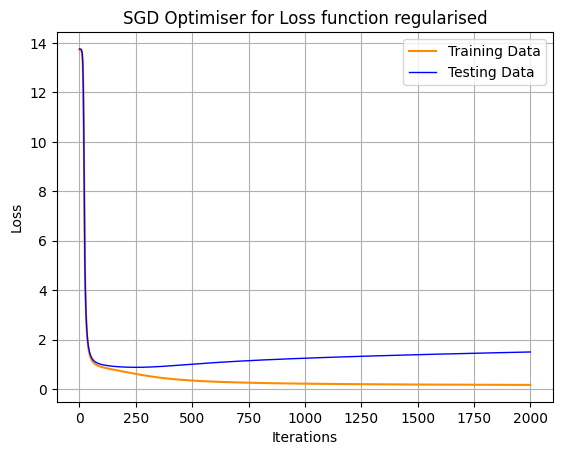

In [63]:
lw = 1
%matplotlib inline
plt.plot(loss_result_reg.index, loss_result_reg['train_loss'], color='darkorange', label='Training Data')
plt.plot(loss_result_reg.index,loss_result_reg['test_loss'], color='blue', linewidth=lw, label='Testing Data')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('SGD Optimiser for Loss function regularised')
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 0, 'Iterations')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'SGD Optimiser for Loss function regularised')

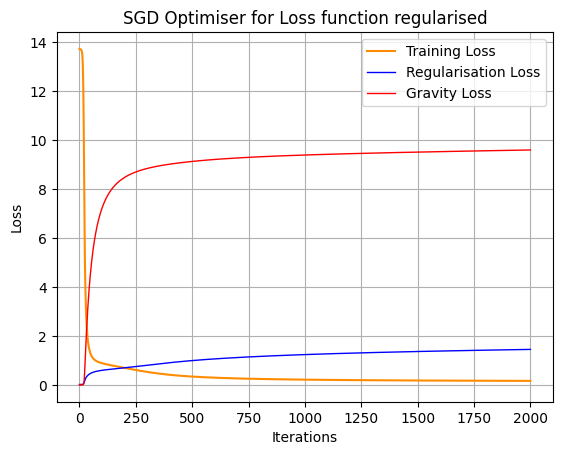

In [64]:
lw = 1
%matplotlib inline
plt.plot(loss_result_reg.index, loss_result_reg['train_loss'], color='darkorange', label='Training Loss')
plt.plot(loss_result_reg.index,loss_result_reg['regularization_loss'], color='blue', linewidth=lw, label='Regularisation Loss')
plt.plot(loss_result_reg.index,loss_result_reg['gravity_loss'], color='red', linewidth=lw, label='Gravity Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('SGD Optimiser for Loss function regularised')
plt.legend()
plt.grid(True)
plt.show()

Observe that adding the regularization terms results in a higher MSE, both on the training and test set. However, as we will see, the quality of the recommendations improves. This highlights a tension between fitting the observed data and minimizing the regularization terms. Fitting the observed data often emphasizes learning high similarity (between items with many interactions), but a good embedding representation also requires learning low similarity (between items with few or no interactions).

#### Inspect the results for regularised model

In [65]:
# Testing of the recommendations
user_id = 10 # Recommendation for this user
measure=COSINE # Use of DOT product or Cosine simialrity
exclude_rated = False # Flag to indicate if already rated movies by this user can be excluded from the final recommendation
k=6 # Number of movies to be recommended
# Create the query embeddings
query_embedding = U_reg.numpy()[user_id]
item_embeddings = V_reg.numpy()
df = user_recommendations(measure,query_embedding,item_embeddings)
score_key = measure+"_"+ 'score'
if exclude_rated:
    # remove movies that are already rated
    rated_movies = ratings[ratings.user_id == user_id]["movie_id"].values
    df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]

df.sort_values([score_key],ascending=False).head(k)

,cosine_score,movie_id,titles,genres
711,0.921,719,Canadian Bacon,"comedy, war"
1259,0.904,1271,North,comedy
1406,0.882,1418,"Joy Luck Club, The",drama
587,0.881,593,Stalingrad,war
706,0.876,714,Carrington,"drama, romance"
617,0.873,623,Angels in the Outfield,"childrens, comedy"


In [66]:
# Testing of the recommendations
user_id = 10 # Recommendation for this user
measure=DOT # Use of DOT product or Cosine simialrity
exclude_rated = False # Flag to indicate if already rated movies by this user can be excluded from the final recommendation
k=6 # Number of movies to be recommended
# Create the query embeddings
query_embedding = U_reg.numpy()[user_id]
item_embeddings = V_reg.numpy()
df = user_recommendations(measure,query_embedding,item_embeddings)
score_key = measure+"_"+ 'score'
if exclude_rated:
    # remove movies that are already rated
    rated_movies = ratings[ratings.user_id == user_id]["movie_id"].values
    df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]

df.sort_values([score_key],ascending=False).head(k)

,dot_score,movie_id,titles,genres
340,5.593,344,"Apostle, The",drama
318,5.587,322,Murder at 1600,"mystery, thriller"
305,5.394,309,Deceiver,crime
132,5.357,133,Gone with the Wind,"drama, romance, war"
50,5.352,51,Legends of the Fall,"drama, romance, war, western"
285,5.243,288,Scream,"horror, thriller"


In [67]:
title_substring="Black" # String to find
measure=COSINE # DOT or Cosine Similarity
k=6 # Number of movies to recommend
score_key = measure+"_"+ 'score'
query_embedding = V_reg.numpy()
item_embeddings = V_reg.numpy()
df = movie_neighbours(title_substring,measure,k,query_embedding,item_embeddings)
df.sort_values([score_key], ascending=False).head(k)

Nearest neighbors of : Men in Black .
[Found more than one matching movie. Other candidates: Black Sheep , Black Beauty , Fear of a Black Hat ]


,cosine_score,movie_id,titles,genres
256,1.000,257,Men in Black,"action, adventure, comedy, sci-fi"
1462,0.896,1474,Nina Takes a Lover,"comedy, romance"
75,0.874,76,Carlito's Way,"crime, drama"
1144,0.874,1155,Rendezvous in Paris,"comedy, romance"
757,0.869,765,Boomerang,"comedy, romance"
1342,0.865,1354,Venice/Venice,drama


In [68]:
title_substring="Black" # String to find
measure=DOT # DOT or Cosine Similarity
k=6 # Number of movies to recommend
score_key = measure+"_"+ 'score'
query_embedding = V_reg.numpy()
item_embeddings = V_reg.numpy()
df = movie_neighbours(title_substring,measure,k,query_embedding,item_embeddings)
df.sort_values([score_key], ascending=False).head(k)

Nearest neighbors of : Men in Black .
[Found more than one matching movie. Other candidates: Black Sheep , Black Beauty , Fear of a Black Hat ]


,dot_score,movie_id,titles,genres
1137,4.282,1148,Tom & Viv,drama
900,4.220,910,Nil By Mouth,drama
256,4.191,257,Men in Black,"action, adventure, comedy, sci-fi"
1160,4.169,1171,Wild Reeds,drama
201,4.155,202,Groundhog Day,"comedy, romance"
57,4.117,58,Quiz Show,drama


In [69]:
import pickle
pickle.dump(U_reg,open('/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/crs_ds/models/matrix_factorisation/user_embedding.pkl','wb'))
pickle.dump(V_reg,open('/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/crs_ds/models/matrix_factorisation/item_embedding.pkl','wb'))